In [432]:
import pandas as pd
import numpy as np
import seaborn as sns  
import matplotlib.pyplot as plt

og_data = pd.read_csv('f1_data_og.csv')

In [433]:
og_data = og_data.rename(columns = {
    'driver_wins': 'team_wins',
    'constructor_wins': 'driver_wins'
})

og_data.columns

Index(['Unnamed: 0', 'season', 'round', 'date', 'driverId', 'grid', 'statusId',
       'position', 'dob', 'driver_nationality', 'team_name',
       'team_nationality', 'GP_circuit', 'country', 'constructorStandingsId',
       'team_wins', 'driverStandingsId', 'driver_wins', 'driver_age',
       'driver_dnf', 'constructor_dnf', 'driver', 'driver_home', 'team_home',
       'race_winner', 'podium_winner', 'pos_delta', 'driver_dnf_ratio',
       'active_driver', 'active_constructor'],
      dtype='object')

Constructing a new data frame to make predictions on race winner or podium winner.

In [434]:
cleaned_df = og_data[['season', 'round','GP_circuit', 'grid','team_name','driver','driver_age', 'driver_wins', 'team_wins', 'pos_delta','driver_dnf_ratio','race_winner', 'podium_winner']]
cleaned_df

,season,round,GP_circuit,grid,team_name,driver,driver_age,driver_wins,team_wins,pos_delta,driver_dnf_ratio,race_winner,podium_winner
0,2009,1,Albert Park Grand Prix Circuit,1,Brawn,Jenson Button,29.0,1,1,0,0.072797,1,1
1,2009,1,Albert Park Grand Prix Circuit,2,Brawn,Rubens Barrichello,37.0,0,1,0,0.089623,0,1
2,2007,1,Albert Park Grand Prix Circuit,14,Honda,Jenson Button,27.0,0,0,0,0.072797,0,0
3,2007,1,Albert Park Grand Prix Circuit,16,Honda,Rubens Barrichello,35.0,0,0,-1,0.089623,0,0
4,2006,3,Albert Park Grand Prix Circuit,1,Honda,Jenson Button,26.0,0,0,0,0.072797,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9557,2021,20,Losail International Circuit,18,Alfa Romeo,Antonio Giovinazzi,28.0,0,0,0,0.081967,0,0
9558,2021,20,Losail International Circuit,19,Haas F1 Team,Mick Schumacher,23.0,0,0,0,0.069767,0,0
9559,2021,20,Losail International Circuit,20,Haas F1 Team,Nikita Mazepin,23.0,0,0,0,0.136364,0,0
9560,2021,20,Losail International Circuit,2,AlphaTauri,Pierre Gasly,26.0,0,0,-2,0.084034,0,0


# Cleaned Data Frame Dictionary

|Feature          |Definition                                             |
|:---------------:|:------------------------------------------------------|
|Season (int)           |The year in which the race takes place                |
|Round (int)            |The specific round in the season |    
|GP_circuit (str) | The circuit at which the race occurs|
|grid (int) | Starting position of each driver|
|team_name (str) | Constructor Name|
|driver (str) | The name of each driver|
|driver_age (int) | The age of each driver|
|driver_wins (int) | The number of wins a driver has in that season at time of race|
|constructor_wins (int) | The number of wins a team has at a specific point in the season|
|pos_delta (int) | How many positions gained or lost in a race|
|driver_dnf_ratio (float) | The ratio of unfinished races to total races entered|
|race_winner (int) | Target Var - binary variable for race winner|
|podium_winner (int)| Target Var - binary variable for podium finisher|

# Data Pre-Processing


In [435]:
#V10 Engine Era is the reason for sectioning of more data to the year 2000 and onwards
cleaned_df = cleaned_df[cleaned_df.season >= 2000]

In [436]:
# Replace Esteban Ocon's grid position with 12
cleaned_df.loc[(cleaned_df['GP_circuit'] == 'Baku City Circuit') & (cleaned_df['season'] == 2023) & (cleaned_df['driver'] == 'Esteban Ocon'), 'grid'] = 12

## One-Hot Encoding

In [437]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 

# Step 1: Encode Categorical Features

# one-hot encoding for 'GP_circuit' and 'team_name':
cleaned_df = pd.get_dummies(cleaned_df, columns=['GP_circuit', 'team_name'])

## Data Splitting

In [438]:
#Train on data from 2000 - 2018
train_data = cleaned_df[(cleaned_df['season'] >= 2000) & (cleaned_df['season'] < 2019)]

#Validate on data from 2019-2022
validation_data = cleaned_df[(cleaned_df['season'] >= 2019) & (cleaned_df['season'] <= 2022)]

#Test on 2023 grand prix using a function we will define after model selection
test_data = cleaned_df[(cleaned_df['season'] == 2023)]

## Function for Splitting and Scaling data 

In [439]:
from sklearn.preprocessing import RobustScaler
def split_data_winner(GP_circuit, train = train_data, val = validation_data, test = test_data):

    """
    GP_circuit = 'GP_circuit_circuit_name'
    """
    gp = GP_circuit

    train = train.loc[train[gp] == 1, :]
    val = val.loc[val[gp] == 1, :]
    test = test.loc[test[gp] == 1, :]

    #X split
    X_train = train.drop(['driver', 'podium_winner', 'race_winner'], axis = 1)
    X_val = val.drop(['driver', 'podium_winner', 'race_winner'], axis = 1)
    X_test = test.drop(['driver', 'podium_winner', 'race_winner'], axis = 1)

    #y split
    y_train = train['race_winner']
    y_val = val['race_winner']
    y_test = test['race_winner']

    scaler = RobustScaler()

    #Only fit on training data and transform on all
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

In [440]:
from sklearn.preprocessing import RobustScaler
def split_data_podium(GP_circuit, train = train_data, val = validation_data, test = test_data):

    """
    GP_circuit = 'GP_circuit_circuit_name'
    """
    gp = GP_circuit

    train = train.loc[train[gp] == 1, :]
    val = val.loc[val[gp] == 1, :]
    test = test.loc[test[gp] == 1, :]

    #X split
    X_train = train.drop(['driver', 'podium_winner', 'race_winner'], axis = 1)
    X_val = val.drop(['driver', 'podium_winner', 'race_winner'], axis = 1)
    X_test = test.drop(['driver', 'podium_winner', 'race_winner'], axis = 1)

    #y split
    y_train = train['podium_winner']
    y_val = val['podium_winner']
    y_test = test['podium_winner']

    scaler = RobustScaler()

    #Only fit on training data and transform on all
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

# Model Building

Making this function dynamic in the sense that we can test our model on different 2023 GP's and predicting both winners and podium placers


In [441]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
def model(GP_circuit, model, prediction, test = test_data):
  """ GP_circuit = 'race_title' <-- get from 2023 race list
      model = 'SVM', 'Logistic Regression', 'Random Forest'
      prediction = 'podium' or 'winner'
  """

  gp = 'GP_circuit_' + GP_circuit

  if prediction == 'podium':
    X_train, X_val, X_test, y_train, y_val, y_test = split_data_podium(gp)
  
  elif prediction == 'winner':
    X_train, X_val, X_test, y_train, y_val, y_test = split_data_winner(gp)

  else:

    raise Exception("Please input a correct prediction type: 'podium' or 'winner'")
 

  if model == 'SVM': 
    svm_mod = SVC(kernel='linear', C=1, random_state=42, probability= True)
    svm_mod.fit(X_train, y_train)
    train_score = svm_mod.score(X_train, y_train)
    val_score = svm_mod.score(X_val, y_val)
    test_score = svm_mod.score(X_test, y_test)

    # print('SVM Train Score:', train_score)
    # print('SVM Validation Score:', val_score)
    # print('SVM Test Score:', test_score)

    #Predict probabilties for test
    probas = svm_mod.predict_proba(X_test)
    # probability of winning
    prob_winning = probas[:,1]

    # predictions
    drivers = test[test[gp] == 1].driver
    results = pd.Series(prob_winning, index=drivers)
    print(results.sort_values(ascending=False))
 
    

    return train_score, val_score, test_score

  elif model == 'Logistic Regression':
    log_reg_mod = LogisticRegression(max_iter = 3000, C=50, penalty='l2')
    log_reg_mod.fit(X_train, y_train)
    train_score = log_reg_mod.score(X_train, y_train)
    val_score = log_reg_mod.score(X_val, y_val)
    test_score = log_reg_mod.score(X_test, y_test)


    # print('Logistic Regression Train Score:', train_score)
    # print('Logistic Regression Validation Score:', val_score)
    # print('Logistic Regression Test Score:', test_score)

    #Predict probabilties for test
    probas = log_reg_mod.predict_proba(X_test)
    # probability of winning
    prob_winning = probas[:,1]

    # predictions
    drivers = test[test[gp] == 1].driver
    results = pd.Series(prob_winning, index=drivers)
    print(results.sort_values(ascending=False))

    return train_score, val_score, test_score
  
  elif model == 'Random Forest':
    rf_mod = RandomForestClassifier(max_depth = 30, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 200)
    rf_mod.fit(X_train, y_train)
    train_score = rf_mod.score(X_train, y_train)
    val_score = rf_mod.score(X_val, y_val)
    test_score = rf_mod.score(X_test, y_test)

    #Predict probabilties for test
    probas = rf_mod.predict_proba(X_test)
    # probability of winning
    prob_winning = probas[:,1]

    # predictions
    drivers = test[test[gp] == 1].driver
    results = pd.Series(prob_winning, index=drivers)
    print(results.sort_values(ascending=False))


    # global_importances = pd.Series(rf_mod.feature_importances_, index = X_train.columns)
    # global_importances.sort_values(ascending=True, inplace=True)
    # global_importances.plot.barh(color='green')
    # plt.xlabel("Importance")
    # plt.ylabel("Feature")
    # plt.title("Global Feature Importance - Built-in Method")

    return train_score, val_score, test_score
  
  else:
    raise Exception("Please enter one of the following models: SVM or Logistic Regression")
        

  




## Predictions for Race Winner on 2023 GP's

Albert Park Grand Prix Circuit
driver
Max Verstappen     0.512361
Sergio Pérez       0.379361
Valtteri Bottas    0.287970
Lewis Hamilton     0.223687
George Russell     0.099558
Lando Norris       0.050586
Fernando Alonso    0.040750
Guanyu Zhou        0.035253
Esteban Ocon       0.034780
Yuki Tsunoda       0.025833
Charles Leclerc    0.024655
Lance Stroll       0.019833
Nico Hülkenberg    0.018528
Kevin Magnussen    0.013528
Carlos Sainz       0.013159
Pierre Gasly       0.011583
Alexander Albon    0.008917
Logan Sargeant     0.008333
Nyck de Vries      0.007417
Oscar Piastri      0.005417
dtype: float64
Bahrain International Circuit
driver
Max Verstappen     0.560833
Charles Leclerc    0.086000
Lewis Hamilton     0.075102
Sergio Pérez       0.073917
George Russell     0.073358
Lando Norris       0.063417
Carlos Sainz       0.061833
Valtteri Bottas    0.042333
Fernando Alonso    0.032208
Nico Hülkenberg    0.014708
Guanyu Zhou        0.014667
Esteban Ocon       0.009667
Yuki Tsunoda  

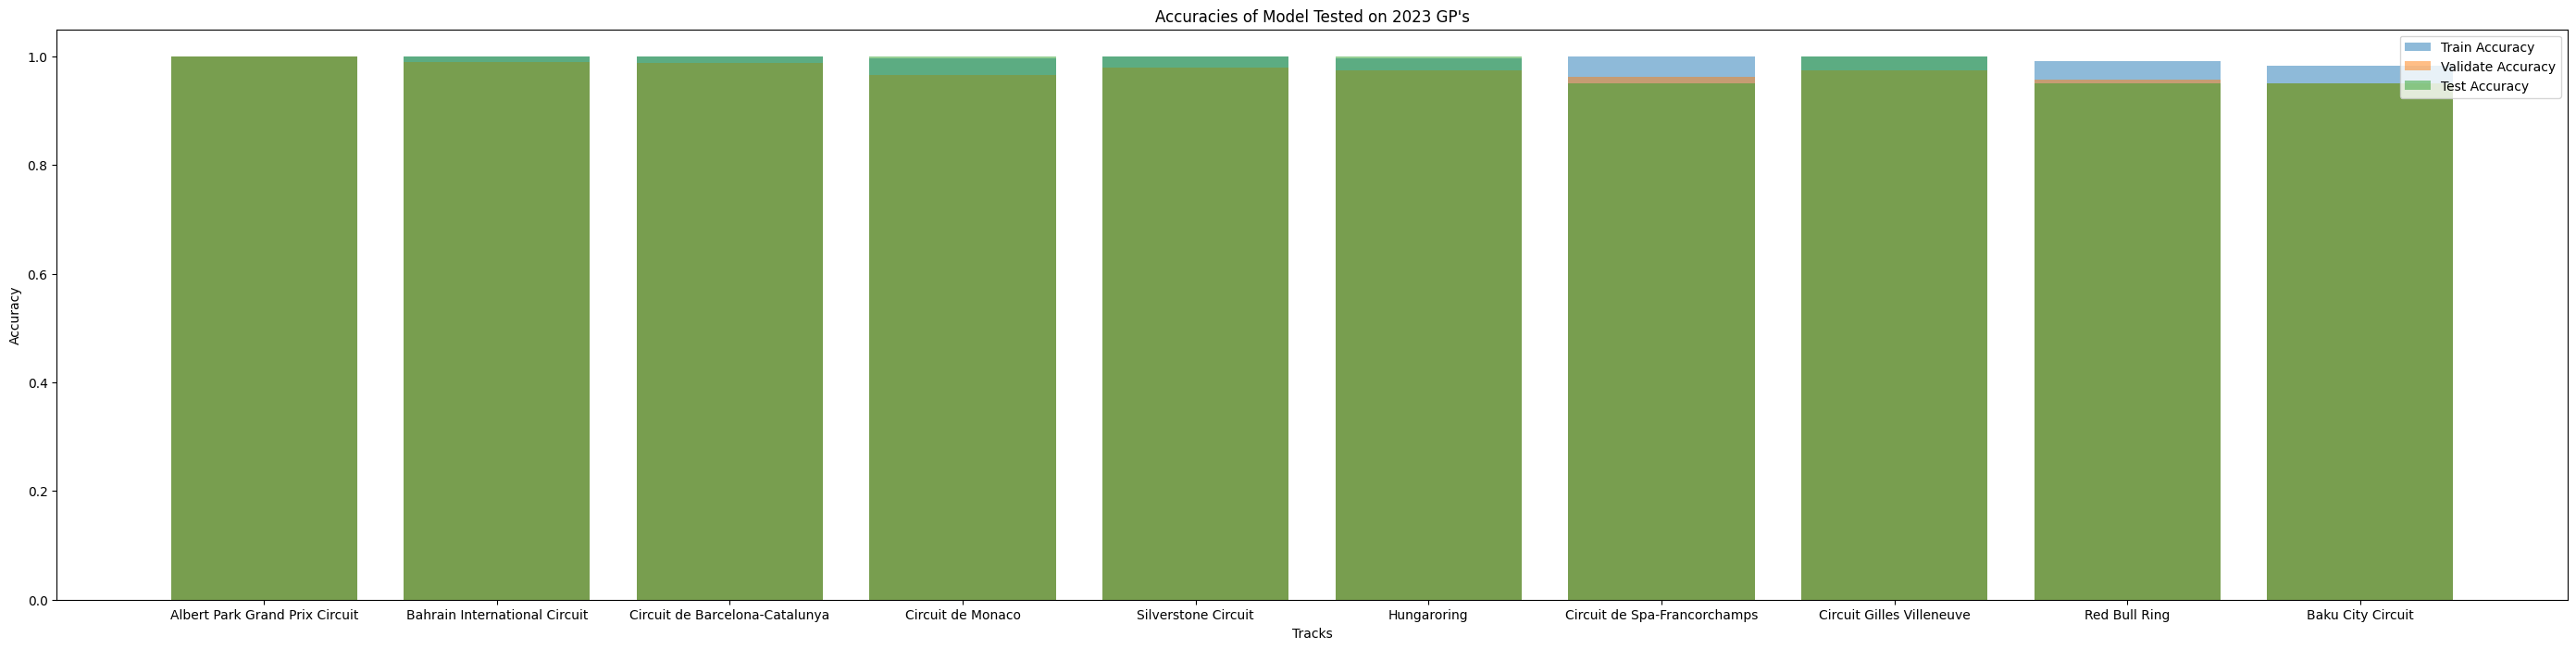

In [442]:
tracks = ['Albert Park Grand Prix Circuit',
 'Bahrain International Circuit',
 'Circuit de Barcelona-Catalunya',
 'Circuit de Monaco',
 'Silverstone Circuit',
 'Hungaroring',
 'Circuit de Spa-Francorchamps',
 'Circuit Gilles Villeneuve',
 'Red Bull Ring',
 'Baku City Circuit']

train_scores = []
val_scores = []
test_scores = []

for track in tracks:
    print(track)
    train_score, val_score, test_score= model(track, 'Random Forest', 'winner')
    train_scores.append(train_score)
    val_scores.append(val_score)
    test_scores.append(test_score)

# Plot accuracies
plt.figure(figsize=(35, 8))
plt.bar([track for track in tracks], train_scores, alpha=0.5, label='Train Accuracy')
plt.bar([track for track in tracks], val_scores, alpha=0.5, label='Validate Accuracy')
plt.bar([track for track in tracks], test_scores, alpha=0.5, label='Test Accuracy')
plt.xlabel('Tracks')
plt.ylabel('Accuracy')
plt.title("Accuracies of Model Tested on 2023 GP's")
plt.legend(loc='best')
plt.show()

Mean Scores for Training and Testing Set:

In [443]:
training_mean = np.mean(train_scores)
testing_mean = np.mean(test_scores)
validation_mean = np.mean(val_scores)

print('The mean training set score is:', training_mean)
print('The mean testing set score is:', testing_mean)
print('The mean Validation set score is:', validation_mean)

The mean training set score is: 0.9969624829690197
The mean testing set score is: 0.985
The mean Validation set score is: 0.9744435028248587


## Predictions for Podium Placers on 2023 GP's

Albert Park Grand Prix Circuit
driver
Max Verstappen     0.788802
Lewis Hamilton     0.766835
George Russell     0.661492
Sergio Pérez       0.654143
Valtteri Bottas    0.317595
Carlos Sainz       0.087389
Fernando Alonso    0.067911
Lando Norris       0.060375
Charles Leclerc    0.056431
Esteban Ocon       0.034929
Nico Hülkenberg    0.027631
Alexander Albon    0.019506
Yuki Tsunoda       0.018720
Pierre Gasly       0.015101
Kevin Magnussen    0.013206
Nyck de Vries      0.011768
Lance Stroll       0.009958
Oscar Piastri      0.009000
Guanyu Zhou        0.008720
Logan Sargeant     0.007256
dtype: float64
Bahrain International Circuit
driver
Sergio Pérez       0.720871
Max Verstappen     0.701756
Charles Leclerc    0.643151
Carlos Sainz       0.229276
Lewis Hamilton     0.155244
George Russell     0.154105
Fernando Alonso    0.075333
Valtteri Bottas    0.071698
Lando Norris       0.069476
Yuki Tsunoda       0.030298
Esteban Ocon       0.027798
Guanyu Zhou        0.023095
Alexander Albo

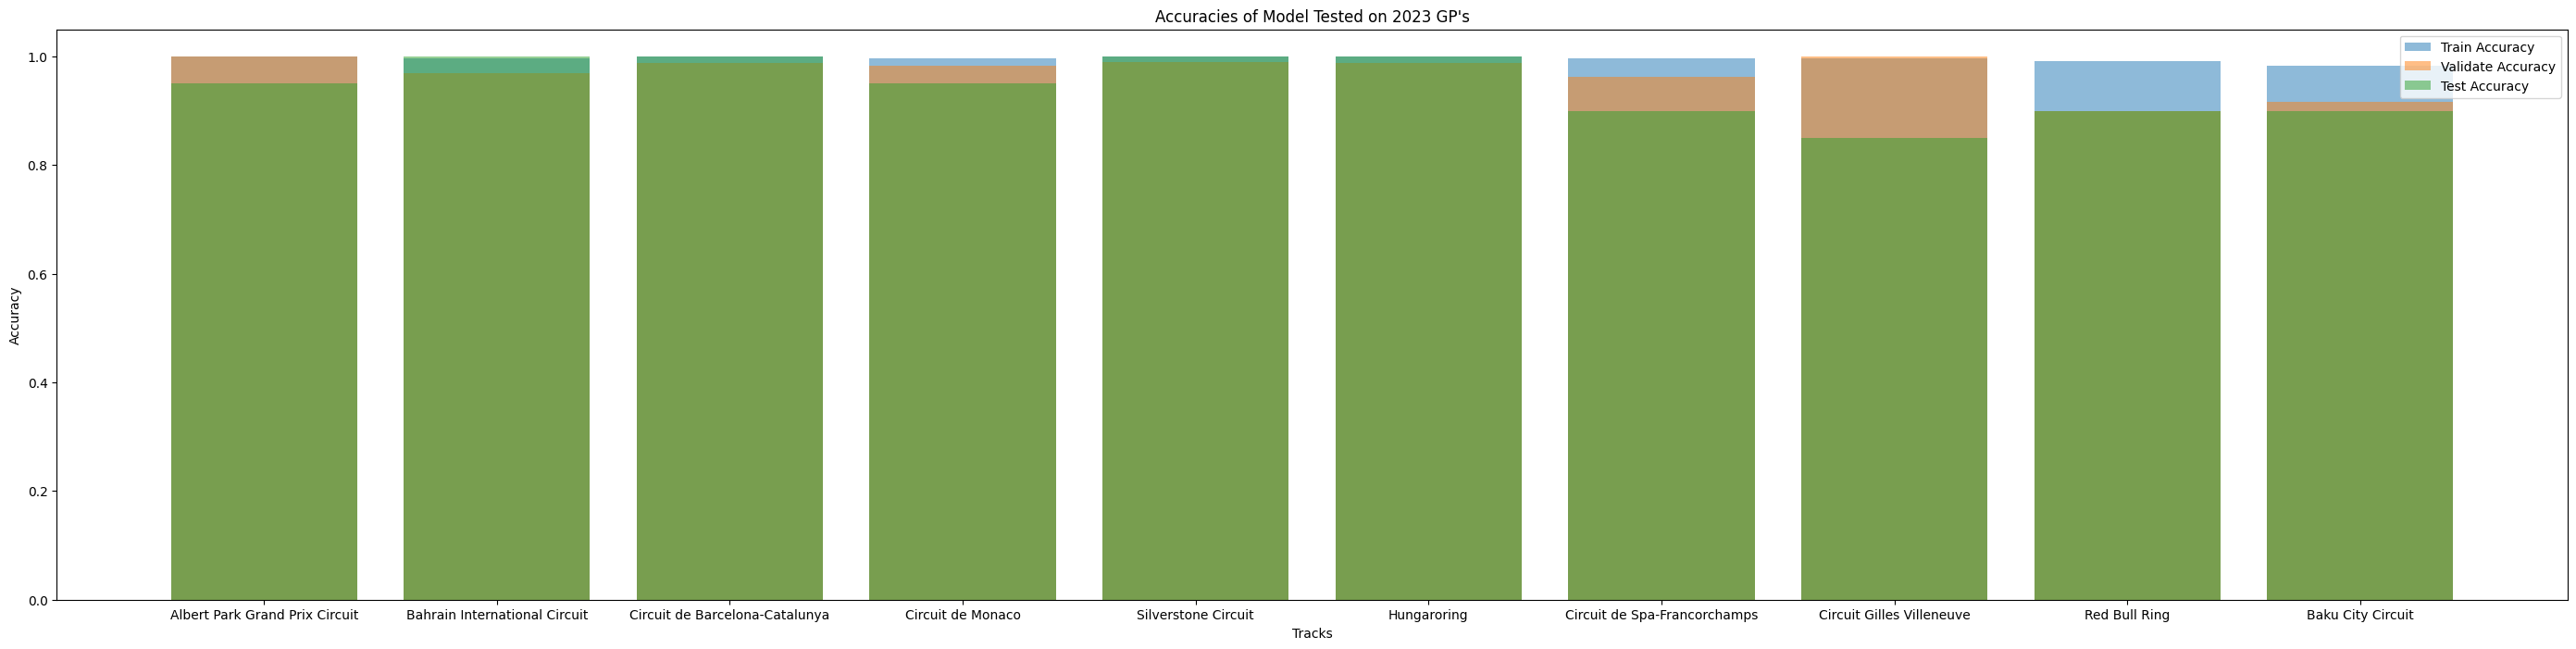

In [444]:
train_scores = []
val_scores = []
test_scores = []

for track in tracks:
    print(track)
    train_score, val_score, test_score= model(track, 'Random Forest', 'podium')
    train_scores.append(train_score)
    val_scores.append(val_score)
    test_scores.append(test_score)
    

# Plot accuracies
plt.figure(figsize=(35, 8))
plt.bar([track for track in tracks], train_scores, alpha=0.5, label='Train Accuracy')
plt.bar([track for track in tracks], val_scores, alpha=0.5, label='Validate Accuracy')
plt.bar([track for track in tracks], test_scores, alpha=0.5, label='Test Accuracy')
plt.xlabel('Tracks')
plt.ylabel('Accuracy')
plt.title("Accuracies of Model Tested on 2023 GP's")
plt.legend(loc='best')
plt.show()




In [445]:
training_mean = np.mean(train_scores)
testing_mean = np.mean(test_scores)
validation_mean = np.mean(val_scores)

print('The mean training set score is:', training_mean)
print('The mean testing set score is:', testing_mean)
print('The mean Validation set score is:', validation_mean)

The mean training set score is: 0.9962664152828017
The mean testing set score is: 0.9450000000000001
The mean Validation set score is: 0.9697217514124293


In [362]:
from scipy.optimize import linprog

def optimize_betting_scipy(drivers, predicted_probs, odds, budget):
    num_drivers = len(drivers)

    # Coefficients for the objective function (negative because linprog does minimization)
    c = -np.multiply(odds, predicted_probs)

    # Inequality constraint matrix: sum of bets <= budget
    A = np.ones((1, num_drivers))
    b = [budget]

    # Bounds for each variable (bet amount)
    bounds = [(0, None) for _ in range(num_drivers)]

    # Solve the linear programming problem
    result = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method='highs')

    # Get the results
    bet_amounts = result.x
    bet_decisions = np.round(bet_amounts)

    # Create a series with drivers as index and bet decisions as values
    bet_series = pd.Series(bet_decisions, index=drivers, name='Bet_Decision')

    return bet_series, bet_amounts  


#Australian GP Betting 

driver = ['Max Verstappen','George Russell','Lewis Hamilton','Lance Stroll','Carlos Sainz','Valtteri Bottas','Fernando Alonso','Charles Leclerc',
'Sergio Pérez','Pierre Gasly','Alexander Albon','Esteban Ocon','Nico Hülkenberg','Yuki Tsunoda','Lando Norris','Kevin Magnussen','Nyck de Vries',
'Guanyu Zhou','Oscar Piastri','Logan Sargeant']

probs = [0.168441,0.119432,0.051617,0.034196,0.03164,0.026693,0.026104,0.020329,0.018161,0.011035,
0.009508,0.005605,0.005253,0.005004,0.002152,0.001807,0.001718,0.000937,0.000903,0.000541]

odds = [1.35,27,23,50,15,1001,9,11,4.01,257,2001,257,1001,2001,751,1001,2001,2001,751,2001]

print("Australian GP Betting Optimization: \n")
optimize_betting_scipy(driver, probs, odds, 100)








Australian GP Betting Optimization: 



(Max Verstappen       0.0
 George Russell       0.0
 Lewis Hamilton       0.0
 Lance Stroll         0.0
 Carlos Sainz         0.0
 Valtteri Bottas    100.0
 Fernando Alonso      0.0
 Charles Leclerc      0.0
 Sergio Pérez         0.0
 Pierre Gasly         0.0
 Alexander Albon      0.0
 Esteban Ocon         0.0
 Nico Hülkenberg      0.0
 Yuki Tsunoda         0.0
 Lando Norris         0.0
 Kevin Magnussen      0.0
 Nyck de Vries        0.0
 Guanyu Zhou          0.0
 Oscar Piastri        0.0
 Logan Sargeant       0.0
 Name: Bet_Decision, dtype: float64,
 array([  0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]))

In [ ]:
driver = ['Sergio Pérez','Max Verstappen','Nico Hülkenberg','Esteban Ocon','Charles Leclerc','Lewis Hamilton','Carlos Sainz',
'Fernando Alonso','Lando Norris','Yuki Tsunoda','Lance Stroll','Oscar Piastri','George Russell',
'Valtteri Bottas','Alexander Albon','Logan Sargeant','Kevin Magnussen','Guanyu Zhou','Pierre Gasly','Nyck de Vries']

odds = [5.19,1.37,1112,527,27,9,37,11,346,2001,92,1365,23,600,578,1667,1365,1501,276,2001]

probs = [0.297906,0.297143,0.109081,0.101915,0.096215,0.086238,0.084634,0.084545,0.069271,0.065782,0.063451,
0.061442,0.059675,0.057686,0.057482,0.049508,0.047843,0.047673,0.043832,0.041852]